In [16]:
# from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import pandas as pd
import sklearn as sk
import numpy as np

In [8]:
df = pd.read_csv('./hyad.csv')

In [9]:
df.head()

,Item,Category,Subcategory
0,"Store Brand Chunky Cinnamon Bread, 1 each",Bakery,Bread
1,"Store Brand French Bread, 16 oz",Bakery,Bread
2,"Store Brand Rye Bread, 1 each",Bakery,Bread
3,"Store Brand Vienna Bread, 16 oz",Bakery,Bread
4,"Store Brand Wheat Bread, 16 oz",Bakery,Bread


In [29]:
# create mappings etween category and category id
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head(200)

,Item,Category,Subcategory,category_id
0,"Store Brand Chunky Cinnamon Bread, 1 each",Bakery,Bread,0
1,"Store Brand French Bread, 16 oz",Bakery,Bread,0
2,"Store Brand Rye Bread, 1 each",Bakery,Bread,0
3,"Store Brand Vienna Bread, 16 oz",Bakery,Bread,0
4,"Store Brand Wheat Bread, 16 oz",Bakery,Bread,0
...,...,...,...,...
195,"Truvia Baking Blend, 24 oz",Baking & Cooking,Seasoning Mix,1
196,"Anderson Maple Syrup Pure, 8 oz",Baking & Cooking,Syrup & Molasses,1
197,"Aunt Jemima Lite Syrup, 24 oz",Baking & Cooking,Syrup & Molasses,1
198,"Aunt Jemima Original Syrup, 24 oz",Baking & Cooking,Syrup & Molasses,1


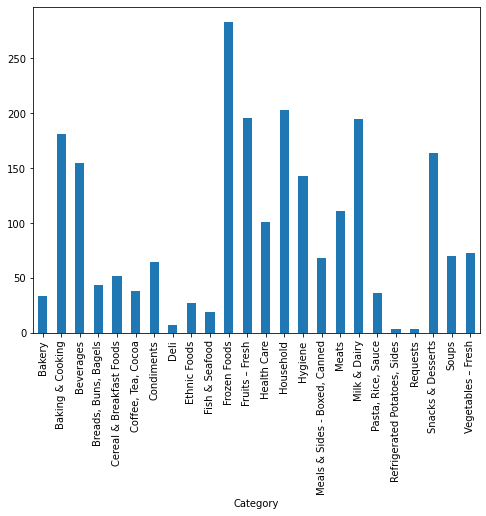

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Item.count().plot.bar(ylim=0)
plt.show()

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(df.Item).toarray()
labels = df.category_id
features.shape

(2268, 1067)

In [37]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
  print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

# 'Bakery':
  . Most correlated unigrams:
. brand
. specify
  . Most correlated bigrams:
. bread 16
. store brand
  . Most correlated trigrams:
. store brand apple
. bread 16 oz
# 'Baking & Cooking':
  . Most correlated unigrams:
. mix
. trends
  . Most correlated bigrams:
. pie filling
. spice trends
  . Most correlated trigrams:
. pudding pie filling
. jell gelatin mix
# 'Beverages':
  . Most correlated unigrams:
. 2l
. soda
  . Most correlated bigrams:
. cnt 12
. soda 2l
  . Most correlated trigrams:
. cnt 12 oz
. 12 cnt 12
# 'Breads, Buns, Bagels':
  . Most correlated unigrams:
. bread
. hearth
  . Most correlated bigrams:
. hearth bread
. village hearth
  . Most correlated trigrams:
. 1st national bagels
. 14 25 oz
# 'Cereal & Breakfast Foods':
  . Most correlated unigrams:
. kellogg
. cereal
  . Most correlated bigrams:
. cereal 12
. general mills
  . Most correlated trigrams:
. cnt 15 oz
. cereal 12 oz
# 'Coffee, Tea, Cocoa':
  . Most correlated unigrams:
. bigelow
. coffee
  . 

In [38]:
# Note that ngrams are not uniquely differentiating between the different categories. Two possible reasons:
# 1. Lack of training data. We only have 2800 items, more may improve the coorelations
# 2. bag-of-words is potentially not the best use case for this mode